In [114]:
using LinearAlgebra
using Plots
include("polynodes.jl")
include("aux_hfd.jl")
include("hfdTypes.jl")
include("postprocess.jl")

Main.HfdPostProcess

In [157]:
occ = Dict(
    -1 => [2 2 2 2 2 2], #s1/2
    1  => [2 2 2 2],   #p1/2
    -2 => [4 4 4 4],   #p3/2
    2  => [4 4 4],     #d3/2
    -3 => [6 6 6],     #d5/2
    3  => [6], #f5/2
    -4 => [8]
    )
#occ = Dict(-1 => [2 2],
#            1 => [2],
#            -2 => [4])
#occ = Dict(-1 => [2])
N, Nprec=120, 250
Z= 80e0
grid = hfd_funcs.leg_rat_grid(N, 0.1Z)
grid_prec = hfd_funcs.leg_exp_grid(Nprec, grid.xs[end])
cpars = hfd_funcs.HfdTypes.CalcParams(80., length(grid.xs))
cpars_prec = hfd_funcs.CalcParams(80., length(grid_prec.xs))
@show(N=length(grid.xs))
occ_block, ztot = hfd_funcs.from_dict(occ, Float64, N)
println("Ztot=$ztot")
@time hfd_funcs.hcore_calc!(cpars, grid, occ_block)
@time hs = hfd_funcs.sc_coul_calc!(cpars, grid, occ_block; tol=1e-8, dump=0.5, maxiter=30);

N = length(grid.xs) = 120
Ztot=80.0
+=========================================================
|Starting calc_occ iterations                             
|atomic charge: 80.0
|fine structure constant: 0.0072973525643
|number of nodes in radial grid: 120
|maximal iteration number: 3
|tolerance: 1.0e-6
|dumping: 0.5 
|aitken accelerated: false
|non-interacting electrons approximation


+=========================================================
iter no: 1
κ      |δpot|
-4  0.0
-3  0.0
-2  0.0
-1  0.0
1  0.0
2  0.0
3  0.0
orbital energies:
[-3532.1920929317675, -904.8477834453729, -392.08368679356283, -216.42474533535, -136.69527097610862, -94.02460731669, -904.8477834454127, -392.08368679358455, -216.42474533259164, -136.6952709799697, -366.14270992777756, -205.57712699416123, -131.19105505319962, -817.8074951999482, -366.1427099338884, -205.57712697626624, -131.1910550534725, -358.9868480372439, -202.53630314135737, -129.6328328481835, -202.53630314136996, -201.07652300418337]
  0.468843

In [146]:
@time hfd_funcs.hfd_calc!(cpars, grid, occ_block; tol=1e-5, dump=0.3, maxiter=25, ecp=nothing);
#@time hfd_funcs.hfd_calc!(cpars, grid, occ_block; tol=1e-8, dump=0.8, maxiter=40, ecp=nothing, aitken=true);

+=========================================================
|Starting calc_occ iterations                             
|atomic charge: 80.0
|fine structure constant: 0.0072973525643
|number of nodes in radial grid: 70
|maximal iteration number: 25
|tolerance: 1.0e-5
|dumping: 0.3 
|aitken accelerated: false
|Dirac Hartree Fock


+=========================================================
iter no: 1
κ      |δpot|
-4  1.8203659889201749
-3  1.1238096586795665
-2  0.0003594781049371456
-1  0.00035954260528928714
1  0.0003596279735863141
2  0.00035953536142155584
3  0.0006740591660423146
orbital energies:
[-3074.9307549614878, -553.2698436445917, -135.3073658959367, -31.93618502510193, -5.615953270327358, -0.4185618994655963, -529.9090248184027, -124.87885960999705, -27.410940892232638, -4.003959567287019, -91.71585522487152, -15.9895639866487, -0.9300227655594626, -457.8157375421204, -108.62071134875364, -23.36976699213194, -3.2442767529285863, -88.23825421390514, -15.209696138038353, -0.83

In [7]:
rep = HfdPostProcess.report(cpars, grid, occ_block)
"klusterization"

#moms = HfdPostProcess.moments(cpars, grid, occ_block)
#klusts = klust(moms[:,2])
#[occ_block.ks occ_block.inds occ_block.ens moms][klusts[1], :]
lhs = zeros(2N, 2N)
rhs = zeros(2N, 2N)
@time hfd_funcs.lhs_rhs!(cpars, grid, -1, occ_block, lhs, rhs; pot_func = hfd_funcs.hfd_pot)
pqs = reshape(occ_block.vecs, :, 2, length(occ_block.ks))
u = lhs * occ_block.vecs[:, 1]
weights = [grid.ws; (cpars.alpha*cpars.Z)^2 .* grid.ws]
gam = sqrt(occ_block.ks[1]^2 - (cpars.alpha*cpars.Z)^2)
pqpq = reshape(lhs, N, 2, N, 2)
for kk=1:N, pq_i=1:2, pq_i2=1:2
    pqpq[kk, pq_i, :, pq_i2] ./=grid.xs
end
hfd_funcs.dirac_h1!(cpars, grid, -1, lhs, rhs)
dot(occ_block.vecs[:, 1], lhs, occ_block.vecs[:, 1])/dot(occ_block.vecs[:, 1], rhs, occ_block.vecs[:, 1])*80^2
function coul_int(cpars, grid, occ_block, k, i1, i2, i3, i4)
    an = cpars.alpha*cpars.Z
    gs = sqrt.(occ_block.ks.^2 .- an^2)
    ls = occ_block.ks
    pqs = reshape(occ_block.vecs, :, 2, length(occ_block.ks))
    p1 = gs[i1] + gs[i2]
    p2 = gs[i3] + gs[i4]
    dens1 .= grid.xs.^

  0.845416 seconds (1.59 M allocations: 85.238 MiB, 93.74% compilation time)


LoadError: ParseError:
[90m# Error @ [0;0m]8;;file:///home/jeral/julia-play/hfd_julia/In[7]#27:23\[90mIn[7]:27:23[0;0m]8;;\
    p2 = gs[i3] + gs[i4]
    dens1 .= grid.xs.^[48;2;120;70;70m[0;0m
[90m#                     └ ── [0;0m[91mpremature end of input[0;0m

In [19]:
#@time hfd_funcs.hfd_calc!(cpars, grid, occ_block; tol=1e-8, dump=0.8, maxiter=40, ecp=nothing, aitken=true, active=klusts[5]);

@time res = hfd_funcs.make_occ_blocks!(cpars, grid, occ_block;
    driver=hfd_funcs.hfd_calc!, dump=0.7, maxiter=20, ecp=nothing, N=Nprec)
#@time refine_calc_multigrid!(cpars, grid, occ_block;driver=hfd_funcs.hfd_calc!, dump=0.7, maxiter=20, ecp=nothing)
#hfd_funcs.

meta iterator with multigrid
occupied states grouped by <r>


9×4 Matrix{Float64}:
 -1.0  1.0  -3067.43    0.0166125
  1.0  2.0   -526.414   0.0570282
 -2.0  1.0   -454.556   0.0656913
 -1.0  2.0   -549.475   0.0692759
  2.0  2.0    -89.3862  0.162286
 -3.0  1.0    -85.9455  0.167111
  1.0  3.0   -122.553   0.170448
 -1.0  3.0   -132.942   0.179898
 -2.0  2.0   -106.414   0.186221

13×4 Matrix{Float64}:
 -1.0  4.0  -30.5821    0.399234
  1.0  4.0  -26.0812    0.401624
 -2.0  3.0  -22.1326    0.434225
  2.0  3.0  -14.7629    0.441672
 -3.0  2.0  -14.013     0.452681
  3.0  2.0   -4.44806   0.476791
 -4.0  1.0   -4.28393   0.483448
 -1.0  5.0   -5.07909   0.915551
  1.0  5.0   -3.5185    0.987268
 -2.0  4.0   -2.81934   1.08003
  2.0  4.0   -0.633348  1.43653
 -3.0  3.0   -0.557447  1.50711
 -1.0  6.0   -0.321019  2.88029

processing cluster 1
+=========================================================
|Starting calc_occ iterations                             
|atomic charge: 80.0
|fine structure constant: 0.0072973525643
|number of nodes in radial grid: 250
|maximal iteration number: 20
|tolerance: 1.0e-6
|dumping: 0.7 
|aitken accelerated: false
|Dirac Hartree Fock


+=========================================================
iter no: 1
κ      |δpot|
-3  9.226471443664328e-7
-2  6.514104769187213e-7
-1  6.515658281274059e-7
1  6.508467773742847e-7
2  6.50447332849157e-7
orbital energies:
[-3067.4397968162552, -549.4963564986741, -132.98298390325525, -30.582087075786063, -5.079092878824213, -0.32101866973616955, -526.4323684735617, -122.59218899712374, -26.081204565904905, -3.5184962080699016, -89.4249742632733, -14.762876033658406, -0.6333475750083614, -454.57674068307085, -106.45490736885183, -22.132575835043014, -2.8193386237342026, -85.98495460866272, -14.013033792313426, -0.5574472636331985, -4.44806

(Main.hfd_funcs.HfdTypes.CalcParams{Float64}[Main.hfd_funcs.HfdTypes.CalcParams{Float64}(80.0, 250, 0.0072973525643), Main.hfd_funcs.HfdTypes.CalcParams{Float64}(80.0, 250, 0.0072973525643)], Main.hfd_funcs.HfdTypes.RatGrid{Float64}[Main.hfd_funcs.HfdTypes.RatGrid{Float64}([6.124254009146369e-5, 0.00032270445608106543, 0.0007931808620665031, 0.0014729242674958035, 0.002362161438904406, 0.003461175473675011, 0.004770313690077157, 0.006289989294748817, 0.008020682040993267, 0.009962938677593196  …  709.1258758848478, 880.8449929851854, 1123.2097997421606, 1481.0299856865247, 2041.2075810285712, 2990.8953299196323, 4796.565425694733, 8907.14584026858, 21893.027762736187, 115360.62360575996], [0.000157170549079231, 0.0003659111062517844, 0.0005750757839248057, 0.0007844482871332032, 0.000994073157263104, 0.0012040127772632485, 0.0014143325135720151, 0.0016250986474838538, 0.001836377962949147, 0.002048237663209408  …  145.7861353909669, 201.67416257442406, 290.19552194240254, 439.105056484

In [ ]:
HfdPostProcess.report(res[1][2], res[2][2], res[3][2])

  N   A   B
 =============================================================================
   1  1s 1/2( 2.00) 0    3074.23499959  .1201472E+08  14.7632   0.0166   0.0218
   2  2s 1/2( 2.00) 0     550.25220048  .1816226E+07  18.2589   0.0692   0.0895
   3  2p 1/2( 2.00) 0     526.85460071  .1346407E+06  24.7599   0.0570   0.0851
   4  2p 3/2( 4.00) 0     455.15650780  .3297927E+09  25.4082   0.0656   0.0851
   5  3s 1/2( 2.00) 0     133.11331813  .4175199E+06  20.9192   0.1798   0.2274
   6  3p 1/2( 2.00) 0     122.63883542  .3473738E+05  28.6792   0.1704   0.2274
   7  3p 3/2( 4.00) 0     106.54505656  .9058503E+08  29.3388   0.1861   0.2386
   8  3d 3/2( 4.00) 0      89.43676167  .7202867E+06  23.4700   0.1622   0.2386
   9  3d 5/2( 6.00) 0      86.02007223  .1384602E+10  23.4700   0.1670   0.2065
  10  4s 1/2( 2.00) 0      30.64831502  .1048862E+06  23.9526   0.3990   0.4805
  11  4p 1/2( 2.00) 0      26.12403533  .8614877E+04  30.0000   0.4016   0.5026
  12  4p 3/2( 4.00) 0      22.18854415  .2261737E+08  30.0000   0.4340   0.5256
  13  4d 3/2( 4.00) 0      14.79670816  .1948660E+06  29.0088   0.4416   0.5744
  14  4d 5/2( 6.00) 0      14.05254829  .3739032E+09  29.0088   0.4525   0.5256
  15  4f 5/2( 6.00) 0       4.47290743  .3157325E+06  28.6792   0.4767   0.7137
  16  4f 7/2( 8.00) 0       4.31170656  .3771175E+09  29.0088   0.4832   0.5256
  17  5s 1/2( 2.00) 0       5.10305540  .2010366E+05  29.0088   0.9152   1.0349
  18  5p 1/2( 2.00) 0       3.53788277  .1461030E+04  30.0000   0.9871   1.1197
  19  5p 3/2( 4.00) 0       2.84194967  .3658245E+07  30.0000   1.0792   1.1641
  20  5d 3/2( 4.00) 0       0.65006541  .1948808E+05  30.0000   1.4312   1.7419
  21  5d 5/2( 6.00) 0       0.57464856  .3533555E+08  30.0000   1.4987   1.5125
  22  6s 1/2( 2.00) 0       0.32803482  .1701671E+04  30.0000   2.8434   3.2211
  =============================================================================
 -1.0  4.0  -30.6412   1.0  0.399234  0.179964
  1.0  4.0  -26.1396   1.0  0.401624  0.18358
 -2.0  3.0  -22.1918   1.0  0.434225  0.214329
  2.0  3.0  -14.8206   1.0  0.441672  0.225441
 -3.0  2.0  -14.0709   1.0  0.452681  0.236589
  3.0  2.0   -4.5037   1.0  0.476791  0.273419
 -4.0  1.0   -4.33961  1.0  0.483448  0.281584
 
 -1.0  5.0  -5.10376   1.0  0.915551  0.940475
  1.0  5.0  -3.54371   1.0  0.987268  1.10236
 -2.0  4.0  -2.84533   1.0  1.08003   1.32099
  2.0  4.0  -0.656923  1.0  1.43653   2.44069
 -3.0  3.0  -0.580446  1.0  1.50711   2.70216

In [ ]:
@time hfd_funcs.exc_pot(cpars, grid, occ_block, -1)

In [ ]:
@time hfd_funcs.sc_coul(cpars, grid, occ_block, -1)

In [ ]:
res = zeros(160, 160)
@time hfd_funcs.exc_func!(cpars, grid, -1, -1, occ_block.vecs[1], occ_block.occs[1], res)

In [ ]:
include("recp.jl")
using .GausECP
#mercury gatchina sorep
lblk = ECPL{Float64}[]
soblk = ECPL{Float64}[]
Nel=60
GausECP.perm = [3, 2, 1]
@ecp_blk lblk begin
 @_r -0.1533054417518667      0   1.241333580354307     
 @_r -2.395038143828458      1   7607.844317587697     
 @_r -3.083263090901668      1   841.1986644533526     
 @_r -20.66235084776708      1   198.9245934440317     
 @_r 43.47025508227014      1   141.3340650803564     
 @_r -41.42648254134264      1   92.24922902157708     
 @_r 10.70202499663918      1   57.53558485747016     
 @_r -9.572044818027125      1   37.05658452036516     
 @_r -17.44928603918218      1   11.09672300653557     
 @_r -4.208396455548661      1   5.176912498322142     
 @_r -1.367889736495112      1   2.774923794909799     
 @_r -0.4243813243216499E-003 1  0.1483608850844247     
 @_r -0.5929678514352788E-005 1  0.6866747702550722E-002
end
@ecp_blk lblk begin
     @_r 10.15330544175187       0   75.45042348565966   
     @_r 48.25843608738218       1   5.516150757473351   
     @_r 480.6203389985901       2   51.33814200088347   
    @_r -262.7712529434285       2   21.42160330126189   
     @_r 984.4925014757564       2   15.02174622132596   
    @_r -1185.343491168202       2   10.41942310721764   
     @_r 895.8591924660080       2   7.044823824714383   
    @_r -446.6972167857539       2   4.654867356257943   
     @_r 187.8018689733064       2   3.105341217453005   
    @_r -77.40249900076539       2   2.110106791683100   
     @_r 28.57866221128257       2   1.397719288132955   
    @_r -10.31101877476388       2  0.9439204802242250   
     @_r 2.910507016043967       2  0.6346119391590400   
   @_r -0.5716441707929951       2  0.4195337735684076   
    @_r 0.5859843273819665E-001  2  0.2726300506225667   
end
@ecp_blk lblk begin
   @_r 9.153305441751867       0   17.82507436921039        
   @_r 7.620198745806825       1   30.37695602101245        
   @_r 40.16962543708902       1   2.310740519807635        
  @_r -164.0019177645640       2   17.82504671620828        
   @_r 474.2514077674568       2   12.10181863115705        
  @_r -643.4432423810800       2   8.036404872508950        
   @_r 588.4002403856621       2   5.818624035188340        
  @_r -227.4981410970566       2   4.100987052252767        
  @_r -11.32937197613574       2   2.216070578260750        
  @_r -2.859429122040108       2   1.333249311891608        
  @_r 0.7947134802086527       2  0.7455844056608246        
 @_r -0.2229856343783364       2  0.4124123361330905        
  @_r 0.5839600759664158E-001  2  0.2194203883781155        
 @_r -0.1537771398331559E-001  2  0.1230722448993955     
  @_r 0.2430273117120762E-002  2  0.7296494669739809E-001
end
@ecp_blk lblk begin
   @_r 7.153305441751867      0   23.21377576628131      
  @_r -2.144639474061312      1   26.10780773207126      
   @_r 65.89001575081436      1   6.951131994354646      
  @_r -15.42058859523037      1   4.403942853245356      
  @_r -51.58323733116725      2   5.100216264970559      
   @_r 110.8021601784391      2   3.219262698530238      
  @_r -54.95719791070449      2   2.300462248784210      
   @_r 11.76944480623374      2   1.528087159313657      
  @_r -1.304739967169114      2  0.8115270441625856      
  @_r 0.2393217597580563      2  0.4291099486615543      
 @_r -0.4535234615374955E-001 2  0.2254312599912531      
  @_r 0.7747797598180014E-002 2  0.8402807013053894E-001 
 @_r -0.3601488445243359E-002 2  0.4516649928935540E-001 
  @_r 0.1119859476515526E-002 2  0.2504140674511687E-001 
 @_r -0.1821995770439212E-003 2  0.1452539607011488E-001 
end
@ecp_blk lblk begin
    @_r 4.153305441751867     0  0.6768910451935157      
    @_r 59.34201069372035     1   88.91809768600156      
   @_r -37.60918087587240     2   1086.775014787427      
   @_r -79.56194030509143     2   675.5596416277371      
   @_r -335.0124022349072     2   165.4780737519513      
    @_r 183.6728097442637     2   32.45662920610522      
    @_r 165.4744951110425     2   9.126231853126143      
   @_r -136.0311282782796     2   6.012492259965792      
    @_r 143.0064886699650     2   3.505612533112329      
   @_r -113.9945474034395     2   2.178173862269087      
    @_r 121.4376695804941     2   1.294122910515299      
   @_r -73.06442644429838     2  0.9322969459551654      
    @_r 12.08767938333994     2  0.6768931808674640      
end
@ecp_blk soblk begin
    @_r 2.33399457129762  1     30.37695602101245  
   @_r -1.54926388536551  1      2.31074051980764  
  @_r -38.17988766177815  2     17.82504671620828  
   @_r 82.79783496886466  2     12.10181863115705  
  @_r -58.85347280654781  2      8.03640487250895  
  @_r -10.37959113417576  2      5.81862403518834  
   @_r 39.37189964009465  2      4.10098705225277  
   @_r -9.08333857917080  2      2.21607057826075  
    @_r 3.69705947137211  2      1.33324931189161  
   @_r -1.06322690698226  2      0.74558440566082  
    @_r 0.30715900767899  2      0.41241233613309  
   @_r -0.08396259856007  2      0.21942038837812  
    @_r 0.02228051512489  2      0.12307224489940  
   @_r -0.00351899693552  2      0.07296494669740  
end
@ecp_blk soblk begin
  @_r -0.41733455916356  1     26.10780773207126   
   @_r 0.97274463182258  1      6.95113199435465   
  @_r -0.52375725997839  1      4.40394285324536   
  @_r -3.74556386224486  2      5.10021626497056   
   @_r 2.56937879347424  2      3.21926269853024   
   @_r 0.95373846965646  2      2.30046224878421   
  @_r -0.88965926027939  2      1.52808715931366   
   @_r 0.21325692813968  2      0.81152704416259   
  @_r -0.05367393973439  2      0.42910994866155   
   @_r 0.01205720847536  2      0.22543125999125   
  @_r -0.00233175961945  2      0.08402807013054   
   @_r 0.00112079580463  2      0.04516649928936   
  @_r -0.00035450482483  2      0.02504140674512   
   @_r 0.00005882336947  2      0.01452539607011   
end
@ecp_blk soblk begin
   @_r 0.00810962564509  1     88.91809768600156   
  @_r -0.16013674443739  2   1086.77501478742693   
  @_r -0.17281127425240  2    675.55964162773705   
  @_r -0.06535456696494  2    165.47807375195131   
  @_r -0.03967362070847  2     32.45662920610522   
   @_r 0.21851422563780  2      9.12623185312614   
  @_r -0.21083072366221  2      6.01249225996579   
   @_r 0.25824759797377  2      3.50561253311233   
  @_r -0.45339487218633  2      2.17817386226909   
   @_r 0.24352517571891  2      1.29412291051530   
  @_r -0.06258006221000  2      0.93229694595517   
   @_r 0.01631215943744  2      0.67689318086746   
end
ecp = RECP.ECPnum(Nel*0e0, lblk, soblk);

In [ ]:
grid_ecp = hfd_funcs.leg_rat_grid(250, 1e0)
cpars_ecp = hfd_funcs.CalcParams(20e0, length(grid_ecp.xs), 1e-6)

In [ ]:
occ_ecp = Dict(
    -1 => [2 2], #s1/2
    1 => [2],    #p1/2
    -2 => [4],   #p3/2
    2 => [4],    #d3/2
    -3 => [6]) #5s2 5p6 5d10 6s2
occ_block_ecp, ztot=hfd_funcs.from_dict(occ_ecp, Float64, length(grid_ecp.xs))
occ_block_ecp.inds[occ_block_ecp.ks .>0] .-= 1;

In [ ]:
hfd_funcs.hcore_calc!(cpars_ecp, grid_ecp, occ_block_ecp; ecp=ecp)
hfd_funcs.sc_coul_calc!(cpars_ecp, grid_ecp, occ_block_ecp; ecp=ecp, tol=1e-4, dump=0.3);

In [ ]:
hfd_funcs.hfd_calc!(cpars_ecp, grid_ecp, occ_block_ecp;ecp=ecp, dump=0.7, maxiter=20, tol=1e-8);

In [ ]:
HfdPostProcess.report(cpars_ecp, grid_ecp, occ_block_ecp)

In [ ]:
-1.0  5.0     -5.08949   1.0  0.915576   0.940498
 -2.0  4.0     -2.83016   1.0  1.07983    1.32033
  1.0  5.0     -3.52905   1.0  0.987247   1.10224
 -3.0  3.0     -0.566696  1.0  1.51386    2.91261
  2.0  4.0     -0.643041  1.0  1.43354    2.42879
 -1.0  6.0     -0.325123  1.0  2.85594    9.44103

In [ ]:
argmax([0 1 0;
        2 -1 0;
        0 0  0])[1]

In [ ]:
@time hfd_funcs.exc_pot(cpars, grid, occ_block, -3)

In [ ]:
@time lhs, rhs = hfd_funcs.dirac_h1(cpars, grid, -3)

In [ ]:
@time mat = lhs .+ hfd_funcs.sc_coul(cpars, grid, occ_block, -3)
@time mat = lhs .+ hfd_funcs.exc_pot(cpars, grid, occ_block, -3)
@time eigen(mat, rhs)

In [ ]:
@time hfd_funcs.hfd_calc!(cpars, grid, occ_block; tol=1e-8, dump=0.7, maxiter=1, ecp=nothing)

In [ ]:
function get_states(cpars, grid, occ_block, ks, inds; pot_func, ecp=nothing)
    κs = sort(unique(ks))
    lhs = zeros(eltype(grid.xs), 2*cpars.N, 2*cpars.N)
    rhs = zeros(eltype(grid.xs), size(lhs))
    vecs = zeros(eltype(grid.xs), 2*cpars.N, length(inds))
    ens = zeros(eltype(grid.xs), length(inds))
    for κ in ks
        mask = κ .== ks
        hfd_funcs.dirac_h1!(cpars, grid, κ, lhs, rhs)
        @views lhs .+= pot_func(cpars, grid, occ_block, κ)
        if ecp!=nothing
            ecpval = ecp(cpars, grid, κ)
            @views lhs[diagind(lhs)] .+= [ecpval; ecpval.*(cpars.alpha^2*cpars.Z^2)]
        end
        vals, aux = eigen(lhs, rhs)
        for v_ii in findall(mask)
           # println("v_ii is $v_ii")
            els = real(vals) .> -1e0
            @views vecs[:, v_ii] .= hfd_funcs.normalize!(cpars, grid, aux[:, els][:, inds[v_ii]], κ, 
                    hfd_funcs.rcut(vals[els][inds[v_ii]]))
            @views ens[v_ii] = vals[els][inds[v_ii]]*cpars.Z^2
        end
    end
    ens, vecs
end
        
            
            

In [ ]:
ens, vecs = get_states(cpars, grid, occ_block, [-1, -1, -1, -1, -1], [5, 6, 7, 8, 16];
    pot_func = hfd_funcs.hfd_pot)
ens_ecp, vecs_ecp = get_states(cpars_ecp, grid, occ_block_ecp, [-1, -1, -1], [1, 2, 3]; 
    pot_func=hfd_funcs.hfd_pot, ecp=ecp)

In [ ]:
HfdPostProcess.report(cpars, grid, occ_block)

In [ ]:
include("matutils.jl")
vec_prec = MatUtils.project(grid, grid_prec, PolyNodes.Lagrange(grid.ts, occ_block.vecs[1:length(grid.xs), 1]))

In [ ]:
[grid.xs grid_prec.xs[1:80]]

In [ ]:
@time oc_block_prec = hfd_funcs.sh_blk_new_grid(cpars, grid, grid_prec, occ_block);
@time hfd_funcs.hfd_calc!(cpars_prec, grid_prec, oc_block_prec; tol=1e-8, dump=0.8, maxiter=5, ecp=nothing);

In [ ]:
@time oc_block_tst = hfd_funcs.sh_blk_new_grid(cpars_prec, grid_prec, grid, oc_block_prec);

In [ ]:
rcut(en) = log(1e10)/sqrt(2*abs(en))
function sh_blk_new_grid(cpars, old_grid, new_grid, occ_block)
    ks = occ_block.ks
    inds = occ_block.inds
    occs = occ_block.occs
    ens = occ_block.ens
    vecs  = zeros(eltype(new_grid.xs), 2*length(new_grid.xs), length(occ_block.ks))
    pqs = reshape(vecs, :, 2, length(occ_block.ks))
    old_pqs = reshape(occ_block.vecs, :, 2, length(occ_block.ks))
    for kk=1:length(ks), i_pq=1:2
        func = PolyNodes.Lagrange(old_grid.ts, old_pqs[:, i_pq, kk])
        @views pqs[:, i_pq, kk] .= hfd_funcs.HfdTypes.project(old_grid, new_grid, func)
        xmask = new_grid.xs .> rcut(ens[kk]/cpars.Z^2)
        pqs[xmask, i_pq, kk] .= 0e0
    end
    hfd_funcs.HfdTypes.ShellBlock(ks, occs, inds, vecs, ens)
end

In [ ]:
as_pqs(occ_block) = reshape(occ_block.vecs, :, 2, length(occ_block.ks))
pqs1 = as_pqs(occ_block)
pqs2 = as_pqs(oc_block_prec)
scatter(grid.xs, pqs1[:, :, 1]; xaxis =:log)
plot!(grid_prec.xs, pqs2[:, :, 1])

In [ ]:
grid_cutted = hfd_funcs.leg_exp_grid(90, 1e2)
cpars_cutted = hfd_funcs.CalcParams(80e0, length(grid_cutted.xs))
cpot = diag(hfd_funcs.coul_pot(cpars, grid, occ_block, -1))[1:N]
blk_cutted = hfd_funcs.sh_blk_new_grid(cpars, grid, grid_cutted, occ_block)
lhs, rhs = hfd_funcs.dirac_h1(cpars_cutted, grid_cutted, -1)
new_pot = hfd_funcs.HfdTypes.project(grid, grid_cutted, PolyNodes.Lagrange(grid.ts, cpot))
exc = hfd_funcs.exc_pot(cpars_cutted, grid_cutted, blk_cutted, -1)
lhs .+= diagm([new_pot; (cpars_cutted.alpha*cpars_cutted.Z)^2 .* new_pot]) .+ exc
vals, vecs = eigen(lhs, rhs)
mask = (real(vals) .> -1e0) .&& (abs.(imag(vals)) .< 1e-10)
vals[mask].*80^2

In [ ]:
grid_prec = hfd_funcs.leg_rat_grid(Nprec, 1e1)
@time occ_prec = sh_blk_new_grid(cpars, grid, grid_prec, occ_block)
pqs = reshape(occ_block.vecs, :, 2, size(occ_block.vecs, 2))
pqs_prec =  reshape(occ_prec.vecs, :, 2, size(occ_prec.vecs, 2))

In [ ]:
plot(grid_prec.xs, pqs_prec[:, :, 1]; xaxis=:log, ls=:dash)
plot!(grid.xs, pqs[:, :, 1]; ls=:dash)

In [ ]:
typeof(occ_block)

In [ ]:
include("inverse_iter.jl")
kmax = 30
green_funcs = zeros(eltype(grid.xs), cpars.N, cpars.N, kmax+1)
@time for kk=0:kmax
    green_funcs[:, :, kk+1] .= hfd_funcs.HfdTypes.potk_mat(grid, kk)
end
occ_without_s = hfd_funcs.sh_blk_new_grid(cpars, grid, grid, occ_block)
#msk = abs.(occ_without_s.ks) .== 1 #.&& (occ_without_s.inds .== 2)
#occ_without_s.vecs[:, .!msk] .= 0e0
pqs = reshape(occ_without_s.vecs, cpars.N, 2, :)
#@views pqs .*= (1 .- exp.(-2e0 .* grid.xs./grid.xs[1]))
cpot = RadInts.coulpot_func(cpars, grid, occ_without_s;green_funcs=green_funcs)
tmp = zeros(2cpars.N)

In [165]:
@time RadInts.twoelint!(cpars, grid, occ_without_s.vecs[:, 6],
    occ_without_s.ks[6], occ_block, tmp;cpot=cpot, green_funcs=green_funcs)

  0.000457 seconds (381 allocations: 161.453 KiB)


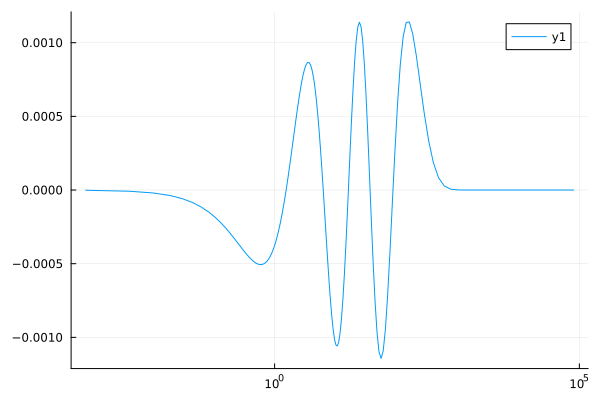

In [167]:
green_funcs[:, :, end]
plot(grid.xs, tmp[1:cpars.N]; xaxis=:log)

In [156]:
hfd_funcs.δnuc(cpars, grid)

70-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [133]:
1 .- exp.(-3grid.xs/grid.xs[1])

70-element Vector{Float64}:
 0.950212931632136
 0.9999998652598653
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 ⋮
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0